# Facial Expression Recognition using Transfer Learning(EfficientNetB0)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50
import cv2


### Dataset

In [2]:
df = pd.read_csv('/kaggle/input/ferdata/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Data Exploration and Preparation

In [3]:
df.emotion.unique()


array([0, 2, 4, 6, 3, 5, 1])

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [5]:
df.emotion.value_counts()


emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

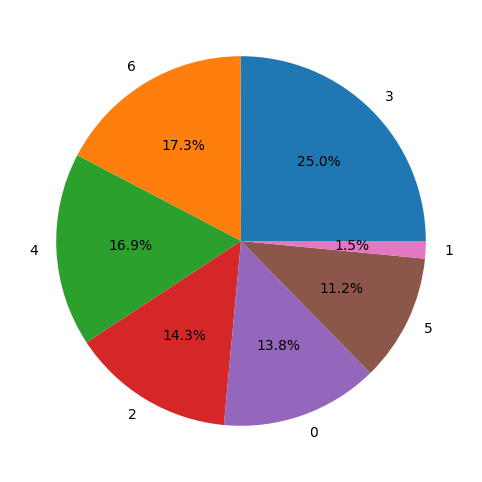

In [6]:
from matplotlib import pyplot as plt
value_counts = df.emotion.value_counts()

emotion_counts = value_counts.values.tolist()
emotions = value_counts.index.tolist()


# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(emotion_counts, labels=emotions, autopct='%1.1f%%')

# Display the chart
plt.show()

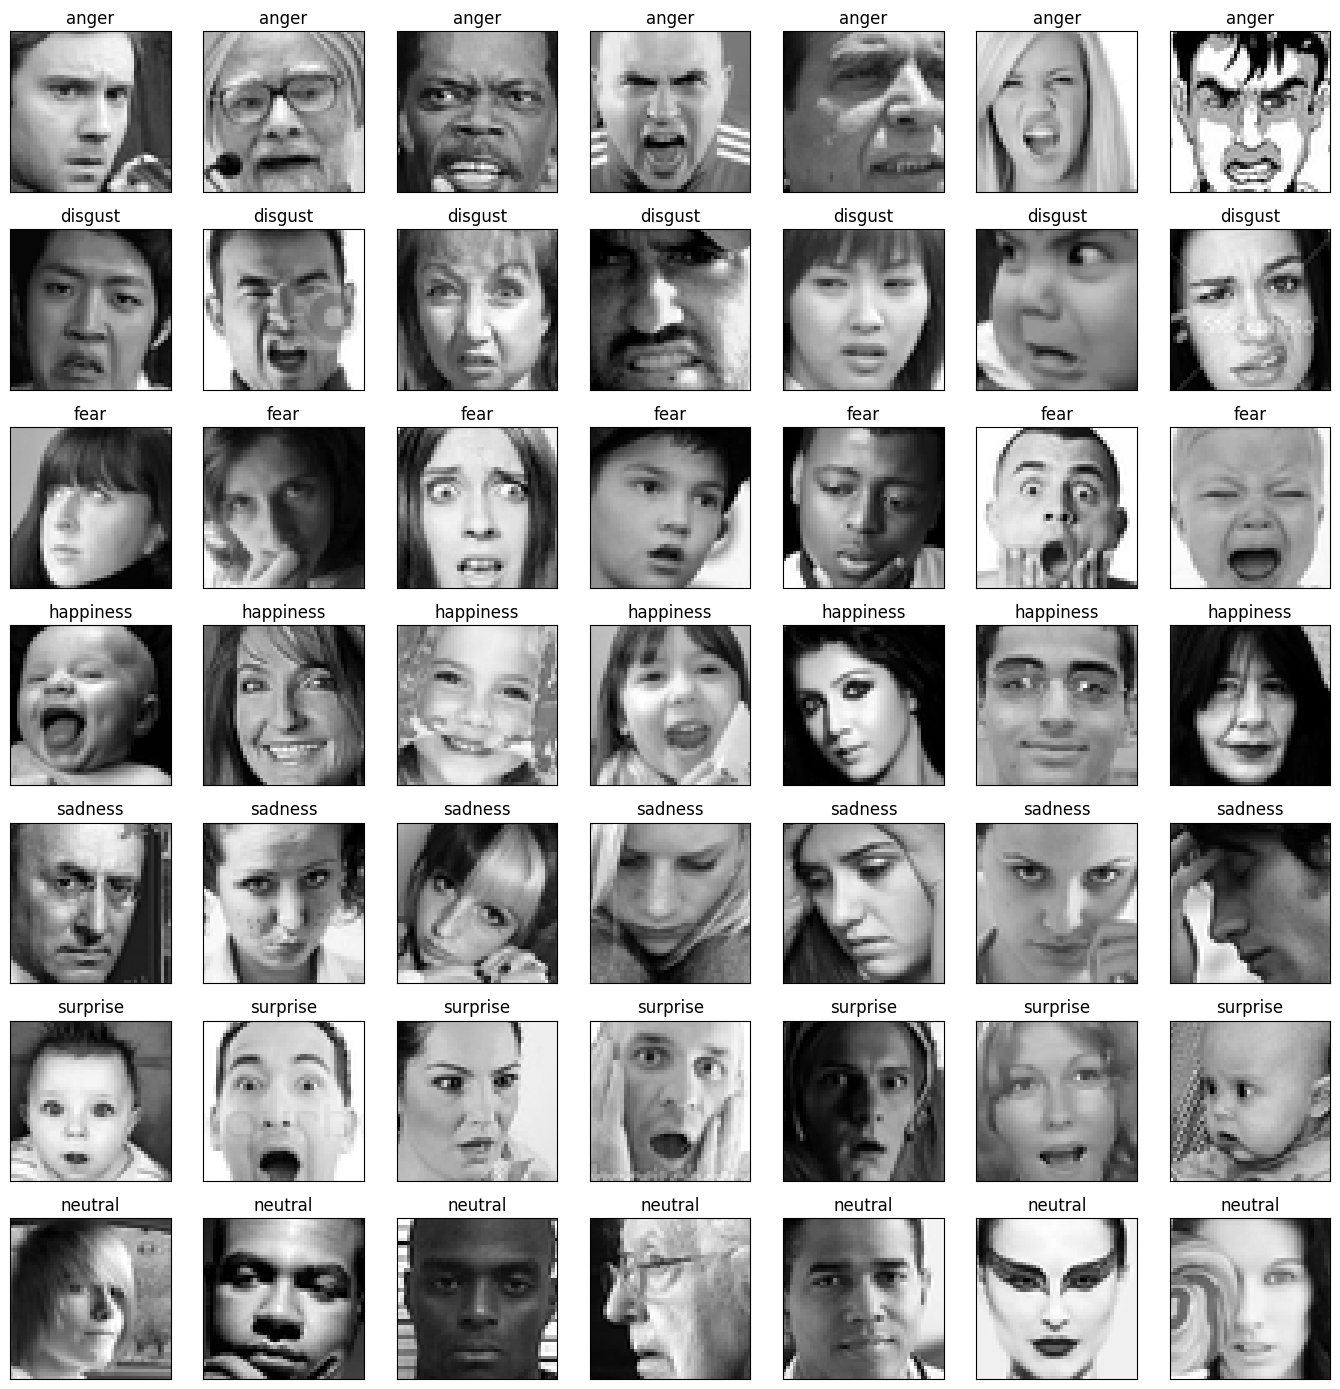

In [7]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [8]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [9]:
img_array.shape


(35887, 48, 48)

In [10]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


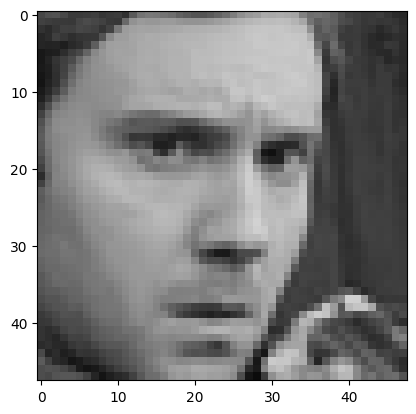

In [11]:
pyplot.imshow(img_features[0].astype(np.uint8));


In [12]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels =to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [13]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### Spliting the data for Training and Validation set

In [14]:
# Initial split: 85% training, 15% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    img_features, img_labels, shuffle=True, stratify=img_labels, test_size=0.15, random_state=42
)

# Further split the training data into training (90% of 85%) and validation (10% of 85%)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, shuffle=True, stratify=y_train_full, test_size=0.1, random_state=42
)

# Display shapes of datasets
print(f"Training set: {X_train.shape}, Validation set: {X_valid.shape}, Test set: {X_test.shape}")
print(f"Training labels: {y_train.shape}, Validation labels: {y_valid.shape}, Test labels: {y_test.shape}")


Training set: (27452, 48, 48, 3), Validation set: (3051, 48, 48, 3), Test set: (5384, 48, 48, 3)
Training labels: (27452, 7), Validation labels: (3051, 7), Test labels: (5384, 7)


In [15]:
del df
del img_features
del img_labels

Normalizing results, as neural networks are very sensitive to unnormalized data

In [16]:
# Normalize the datasets
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0



In [17]:
# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Define a function for data augmentation
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    return image, label

In [18]:
# Apply augmentation, batching, and prefetching
batch_size = 32
train_dataset = (train_dataset
                 .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(buffer_size=1000)
                 .batch(batch_size)
                 .prefetch(buffer_size=tf.data.AUTOTUNE))

valid_dataset = (valid_dataset
                 .batch(batch_size)
                 .prefetch(buffer_size=tf.data.AUTOTUNE))

test_dataset = (test_dataset
                .batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE))


In [19]:
# Model preparation
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

### Model Building

In [20]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load EfficientNetB0 model with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Define custom model head
def build_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

# Add custom head to the EfficientNetB0 base
num_classes = 7  # Example number of classes
custom_head = build_model(base_model, num_classes)
model = Model(inputs=base_model.input, outputs=custom_head)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
print(model.summary())


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 48, 48, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 48, 48, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 48, 48, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 49, 49, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 24, 24,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 24, 24,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 24, 24,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 24, 24,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 24, 24,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 24, 24,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 24, 24,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 24, 24,    │        512 │ block1a_se_excit

 Total params: 4,709,034 (17.96 MB)

 Trainable params: 4,667,011 (17.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

None


In [21]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [22]:
# Optimizer
epochs = 20
optim = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

### Training the Model

In [23]:
# Training the model with tf.data.Dataset
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=epochs,
                    callbacks=callbacks)


Epoch 1/20


I0000 00:00:1725277655.438134     109 service.cc:145] XLA service 0x7fcc44002a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725277655.438186     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725277655.438192     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/858 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.1701 - loss: 2.1712    

I0000 00:00:1725277697.959210     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


858/858 ━━━━━━━━━━━━━━━━━━━━ 145s 80ms/step - accuracy: 0.2480 - loss: 1.9229 - val_accuracy: 0.3822 - val_loss: 1.5986 - learning_rate: 1.0000e-04
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5027 - loss: 1.3064 - val_accuracy: 0.5444 - val_loss: 1.2096 - learning_rate: 1.0000e-04
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5252 - loss: 1.2436 - val_accuracy: 0.5605 - val_loss: 1.1633 - learning_rate: 1.0000e-04
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5483 - loss: 1.1990 - val_accuracy: 0.5631 - val_loss: 1.1478 - learning_rate: 1.0000e-04
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5607 - loss: 1.1592 - val_accuracy: 0.5765 - val_loss: 1.1287 - learning_rate: 1.0000e-04
Epoch 9/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5775 - loss: 1.1221 - val_accuracy: 0.5903 - val_loss: 1.1219 - learning_rate: 1.0000e-04
Epoch 10/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accur

### Evaluate the model on the test dataset

In [29]:
 #Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6134 - loss: 1.0788
Test Loss: 1.0891, Test Accuracy: 0.6090


### Accuracy and Loss Curve

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

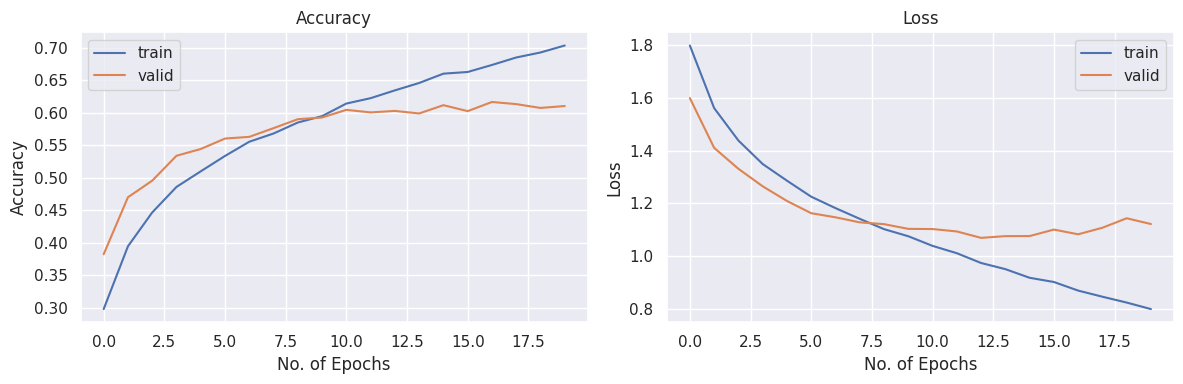

In [30]:
import seaborn as sns
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('No. of Epochs')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('No. of Epochs')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


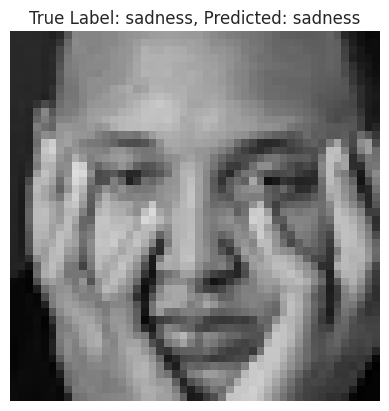

True Label: sadness
Predicted Label: sadness


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a random index from the validation set
random_index = np.random.randint(0, X_valid.shape[0])

# Get the chosen image and its corresponding true label
chosen_image = X_valid[random_index]
true_label = np.argmax(y_valid[random_index])

# Make a prediction
prediction = model.predict(np.expand_dims(chosen_image, axis=0))  # Add batch dimension
predicted_class = np.argmax(prediction, axis=1)[0]

# Display the image and prediction
plt.imshow(chosen_image)
plt.title(f"True Label: {emotion_label_to_text[true_label]}, Predicted: {emotion_label_to_text[predicted_class]}")
plt.axis('off')
plt.show()

print(f"True Label: {emotion_label_to_text[true_label]}")
print(f"Predicted Label: {emotion_label_to_text[predicted_class]}")


### Testing the model on random images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


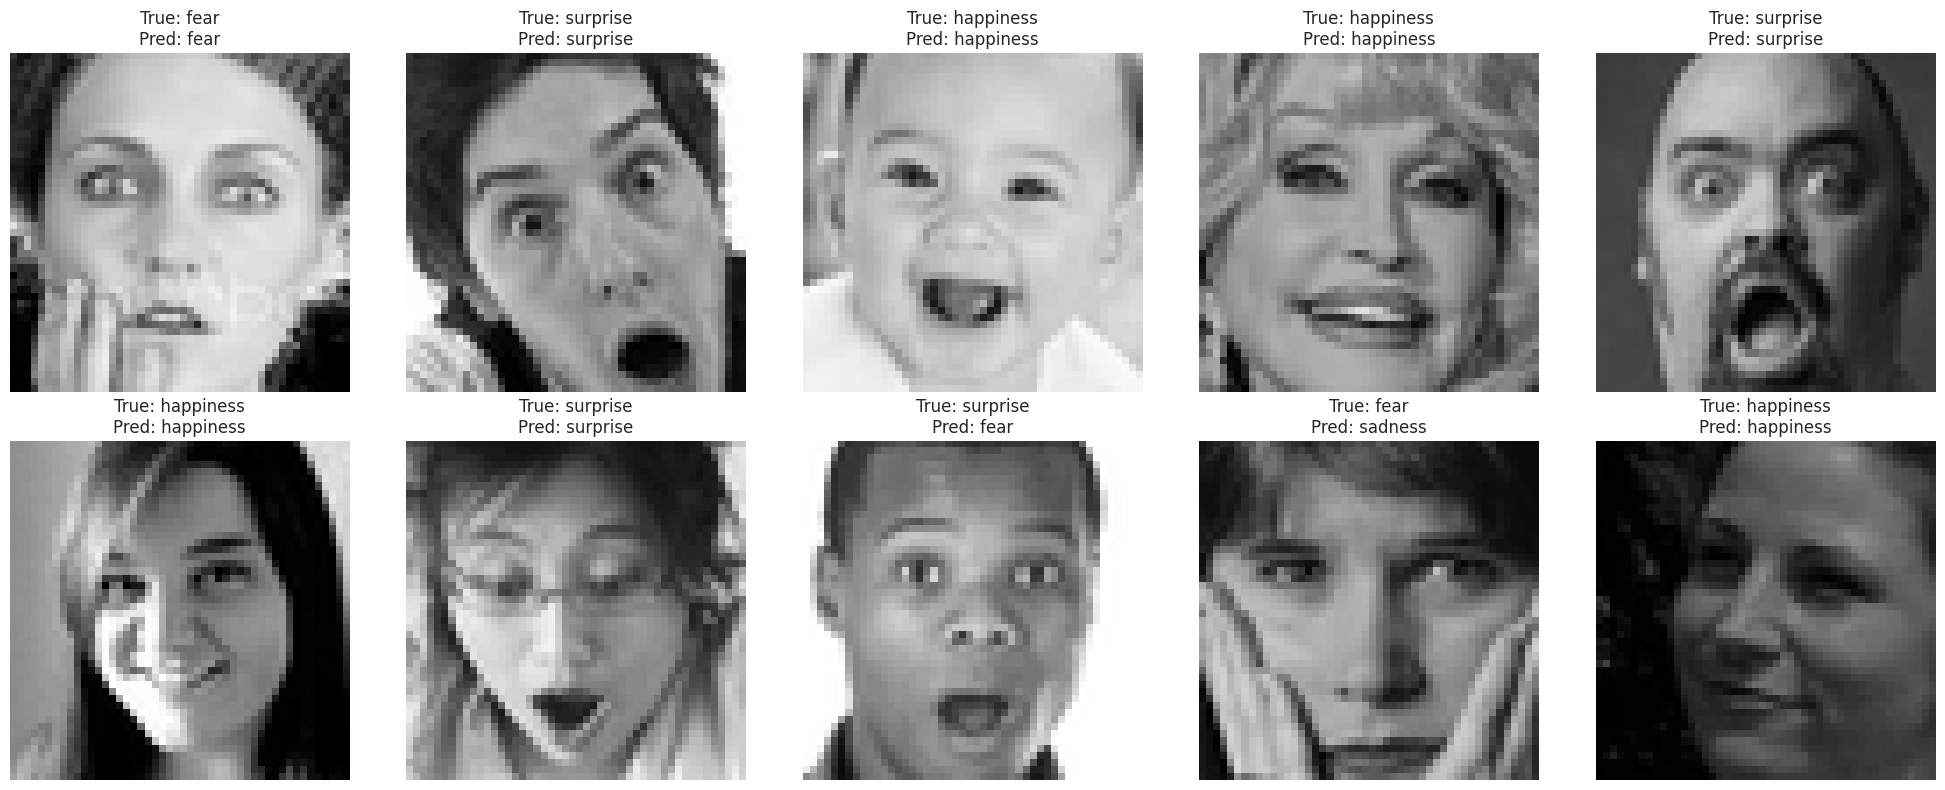

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Number of images to display
num_images = 10
images_per_row = 5
rows = num_images // images_per_row

# Select random indices from the validation set
random_indices = np.random.choice(X_valid.shape[0], num_images, replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(rows, images_per_row, figsize=(20, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the selected indices
for i, ax in enumerate(axes):
    # Get the chosen image and its corresponding true label
    random_index = random_indices[i]
    chosen_image = X_valid[random_index]
    true_label = np.argmax(y_valid[random_index])

    # Make a prediction
    prediction = model.predict(np.expand_dims(chosen_image, axis=0))  # Add batch dimension
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Display the image and prediction
    ax.imshow(chosen_image.squeeze(), cmap='gray')  # Use `squeeze()` to remove extra dimensions
    ax.set_title(f"True: {emotion_label_to_text[true_label]}\nPred: {emotion_label_to_text[predicted_class]}")
    ax.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Model Performance

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<Figure size 700x700 with 0 Axes>

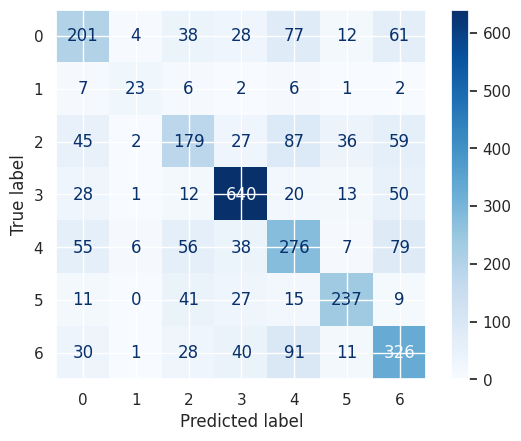

Total wrong validation predictions: 1169


Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.48      0.50       421
           1       0.62      0.49      0.55        47
           2       0.50      0.41      0.45       435
           3       0.80      0.84      0.82       764
           4       0.48      0.53      0.51       517
           5       0.75      0.70      0.72       340
           6       0.56      0.62      0.59       527

    accuracy                           0.62      3051
   macro avg       0.61      0.58      0.59      3051
weighted avg       0.62      0.62      0.61      3051

858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Training Accuracy: 76.49%
Validation Accuracy: 61.68%


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions for the validation set
yhat_valid = model.predict(X_valid)

# Convert one-hot encoded predictions and labels to class indices
y_true = np.argmax(y_valid, axis=1)
y_pred = np.argmax(yhat_valid, axis=1)

# Compute the confusion matrix for validation set
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6']  # Replace with your actual class names

# Set figure size before plotting
plt.figure(figsize=(7, 7))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)

# Save the confusion matrix plot
plt.savefig("confusion_matrix_dcnn.png")

# Show the plot
plt.show()

# Print the total number of wrong validation predictions
print(f'Total wrong validation predictions: {np.sum(y_true != y_pred)}\n\n')

# Print the classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Generate predictions for the training set
yhat_train = model.predict(X_train)  # Assuming X_train is your training data

# Convert one-hot encoded predictions and labels to class indices for training set
y_true_train = np.argmax(y_train, axis=1)  # Assuming y_train is your training labels
y_pred_train = np.argmax(yhat_train, axis=1)

# Calculate and print the training accuracy as a percentage
training_accuracy = accuracy_score(y_true_train, y_pred_train)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')
# Calculate and print the validation accuracy as a percentage
validation_accuracy = accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')
